# Intro to Machine Learning Final Project

## Team member: Mahamitra Jagadheshkumar,  Xikun Yuan



#### The goal of this project is to classify eletro cardiograph signals (ECG) to see if a person has normal or arrhythmic heartbeats.

#### The data is from MIT-BIH arrhythmia database.

#### The format of data is a .dat file. The annotation (labels) from actual doctors is in the .atr file. 

#### To read the .dat file and .atr files, the python package wfdb is used.

In [1]:
import wfdb
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display

#### The function "extract_epochs" below converts a continous data stream into epochs for machine learning.

#### Based on the annotation from the doctor, we identify the center of each heart beat.

#### We take 150 samples before the center of the heart beat, and 150 samples after the heart beat

#### Since the sampling rate is 360 Hz, we are capturing one heart beat per epoch

In [2]:
import matplotlib



def extract_epochs(signal, annotation):
    epochs = None
    labels = []
    symbols = annotation.symbol
    timepoints = annotation.sample
    for i in range(len(timepoints)):
        if i < 3:
            continue
        timepoint = timepoints[i]
        if i == 0:
            prev_timepoint = 0
        else:
            prev_timepoint = timepoints[i-1]
#         print("prev_time point is {}, timepoint is{}".format(prev_timepoint, timepoint))
            
        label = symbols[i-1]
        
        
        if epochs is None:
            epochs = signal[timepoint - 150: timepoint + 150, :]
        elif epochs.shape[0] == 300:
            epochs = np.stack((epochs, signal[timepoint - 150: timepoint + 150, :]))
        else:
            epochs = np.concatenate((epochs, signal[timepoint - 150: timepoint + 150, :].reshape(1, 300, 2)),axis = 0)

        labels.append(label)
    return epochs, labels



#reading one file to look at the size of training epochs
f = '100'
filename = 'C:\\Users\\Kun\\ecg\\' + f
record = wfdb.rdsamp(filename, sampto = 15000)
signal, fields = wfdb.srdsamp(filename, sampfrom=800)
annotation = wfdb.rdann(filename, 'atr', sampto = 15000)
epochs, labels= extract_epochs(signal, annotation)
epochs = np.array(epochs)
labels = np.array(labels)
print(epochs.shape)
print(labels.shape)


# fig = plt.figure(figsize=(4,1))
# gs  = matplotlib.gridspec.GridSpec(4, 1)
# ax0 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[1])
# ax2 = plt.subplot(gs[2])
# ax3 = plt.subplot(gs[3])

# fig.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
# ax1.plot(epochs[4])
# ax2.plot(epochs[5])
# ax3.plot(epochs[6])
# ax0.plot(epochs[7])

# plt.show()

(49, 300, 2)
(49,)


#### The code below iterates through all the data files and makes them into epochs and aggregates them together

In [3]:

files = ['100','101','102','103','104','105', '106', '107','108', '109','111','112','113','114','115', '116','117','118','119', '121','122','123',
         '124', '200','201','202','203','205','207','208','209',
        '210','212','213','214','215','217','219','220','221',
        '223','228','230','231','232','233','234']
labels_total = []
epochs_total = None

for f in files:
    filename = 'C:\\Users\\Kun\\ecg\\' + f

    signal, fields = wfdb.srdsamp(filename, sampfrom = 0)
    annotation = wfdb.rdann(filename, 'atr', sampto = 50000)
    epochs, labels= extract_epochs(signal, annotation)
    
    if epochs_total is None:
        epochs_total = epochs
    else:
        epochs_total = np.concatenate((epochs_total, epochs))
    labels_total = labels_total + labels

labels_total = np.array(labels_total)
    
print(epochs_total.shape)
print(labels_total.shape)


(8394, 300, 2)
(8394,)


#### The function "count_occurance" below counts the number of samples for each class.

#### As we can see from the output, there are way more normal hearbeats than other arrhythmic heartbeats.

#### We have to balance the samples for each class to prevent overfitting to one class.

In [4]:
def count_occurance(labels_total):
#     labels_total = labels_total.tolist()
    unique_label, occurance = np.unique(labels_total, return_counts = True)
    for i in range(len(unique_label)):
        print("the occurance of {} is: {}".format(unique_label[i], occurance[i]))
        
count_occurance(labels_total)



the occurance of ! is: 44
the occurance of " is: 27
the occurance of + is: 90
the occurance of / is: 522
the occurance of A is: 114
the occurance of F is: 51
the occurance of L is: 568
the occurance of N is: 5755
the occurance of Q is: 3
the occurance of R is: 553
the occurance of V is: 532
the occurance of [ is: 2
the occurance of ] is: 2
the occurance of a is: 4
the occurance of e is: 1
the occurance of f is: 69
the occurance of x is: 2
the occurance of | is: 18
the occurance of ~ is: 37


#### Since most of the heartbeats will be normal, we have to control the number of normal samples, otherwise the model will overfit to "normal" and classify everything to be "normal."

#### We limit the max number of normal heart beat to be 700, since next most frequent class is "L", 568.

#### Some classes, such as "e", "a", "[", "]" are too rare. Therefore we only take 6 of the most common classes.

In [5]:
count_N = 0
max_N = 700
epochs_new = None
labels_new = list()
for index, epoch in enumerate(epochs_total):
    if labels_total[index] not in ['/', 'A','L','N','R','V']:
        continue
    epoch = epoch.reshape(1, 300, 2)
    if count_N > max_N and labels_total[index] == 'N':
        continue
    if labels_total[index] == 'N':
        count_N = count_N +1

    if epochs_new is None:
        epochs_new = epoch
    else:
        epochs_new = np.concatenate((epochs_new, epoch))

        
    labels_new = labels_new + list(labels_total[index])

count_occurance(labels_new)
labels_new = np.array(labels_new)


the occurance of / is: 522
the occurance of A is: 114
the occurance of L is: 568
the occurance of N is: 701
the occurance of R is: 553
the occurance of V is: 532


#### Now we are taking a naive approach, fitting the time series directly into logistic regression.

#### Under 10-fold cross validation, the accuracy is only 53 percent, as expected.

#### This is because when the time series is shifted even a little bit, the classification of due to logistic regression can vary greatly.

In [6]:


import sklearn # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from sklearn.svm import SVC  # noqa
from sklearn.metrics import classification_report

clf = sklearn.linear_model.LogisticRegression(C=1)

y = labels_new
X = epochs_new

print(X.shape)


# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=42)
scores = []

for train_idx, test_idx in cv.split(labels_new):
    y_train, y_test = y[train_idx], y[test_idx]
    X_train = X[train_idx][:,0]
    X_test = X[test_idx][:,0]
    clf.fit(X_train, y_train)

    # fit classifier
    y_pred = clf.predict(X_test)
    scores.append(clf.score(X_test, y_test))

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


print(classification_report(y_test, y_pred))

(2990, 300, 2)
Classification accuracy: 0.422659 / Chance level: 1.000000
             precision    recall  f1-score   support

          /       0.47      0.65      0.55       110
          A       0.00      0.00      0.00        15
          L       0.47      0.12      0.20       130
          N       0.31      0.69      0.43       131
          R       0.50      0.56      0.53       102
          V       1.00      0.07      0.14       110

avg / total       0.53      0.41      0.35       598



C:\Users\Kun\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Next we take the derivative of the time series and fit it using logistic regression.

#### The result was still low, with around 53% accuracy.

In [7]:
def take_diff(epochs):
    temp = epochs.copy()
    for i in range(epochs.shape[0]):
        for j in range(epochs.shape[1]):
            if j != 0:  
                temp[i, j] = epochs[i,j] - epochs[i,j-1]
    return temp


epochs_diff = take_diff(epochs_new)
print(epochs_new[0, :10, 1])      
print(epochs_diff[0,:10, 1])      

[-0.185 -0.19  -0.195 -0.195 -0.19  -0.185 -0.185 -0.19  -0.2   -0.215]
[-0.185 -0.005 -0.005  0.     0.005  0.005  0.    -0.005 -0.01  -0.015]


In [8]:
clf = sklearn.linear_model.LogisticRegression(C=1)

y = labels_new
X = epochs_diff

print(X.shape)


# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=42)
scores = []

for train_idx, test_idx in cv.split(labels_new):
    y_train, y_test = y[train_idx], y[test_idx]
    X_train = X[train_idx][:,0]
    X_test = X[test_idx][:,0]
    clf.fit(X_train, y_train)

    # fit classifier
    y_pred = clf.predict(X_test)
    scores.append(clf.score(X_test, y_test))

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


print(classification_report(y_test, y_pred))

(2990, 300, 2)
Classification accuracy: 0.422659 / Chance level: 1.000000
             precision    recall  f1-score   support

          /       0.47      0.65      0.55       110
          A       0.00      0.00      0.00        15
          L       0.47      0.12      0.20       130
          N       0.31      0.69      0.43       131
          R       0.50      0.56      0.53       102
          V       1.00      0.07      0.14       110

avg / total       0.53      0.41      0.35       598



C:\Users\Kun\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Now we are going to use convolutional neural networks to classify ECG signals.

#### Since the 6 classes have to be converted from symbols to numbers, the function below is created to perform this job.

In [9]:
def convert_sign_into_num(labels):
    unique = np.unique(labels)
    num = np.arange(len(unique))
    zipped = dict(zip(unique, num))
    labels_num = []
    for i in labels:
        labels_num.append(zipped[i])
    return labels_num

labels_num = convert_sign_into_num(labels_new)
print( len(np.unique(labels_new)))


6


#### The architecture of the CNN consists of two, 1-D convolution layers, 1 max pooling layer and 2 fully-connected neural networks.

#### Tuning the batch size in our case is crucial to gettting a high accuracy.

#### When the batch size is 64, the accuracy on testing samples is 67%.

#### When the batch size is 32, the accuracy on testing samples is 76%.

#### When the batch size is 8, the accuracy on testing samples is 90%.

#### When the batch size is 1, the accuracy on testing samples is 71%.

In [10]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K

K.clear_session()

cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=42)
scores = []
labels = np.array(labels_num)
epochs_data = epochs_new



for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]
    X_train = epochs_data[train_idx]
    X_test = epochs_data[test_idx]


    num_train = X_train.shape[0]
    num_test = X_test.shape[0]
    print(X_train.shape)
    
#     X_train = np.swapaxes(X_train, 1, 2)
#     X_test = np.swapaxes(X_test, 1, 2)

    print(X_train.shape)

    num_classes = 6

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv1D(8, kernel_size=(30),
                     activation='relu',
                     input_shape=(300,2)))
    model.add(Conv1D(8, kernel_size=(30), activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.01),
                  metrics=['accuracy'])

    model.fit(X_train, y_train,
              batch_size=4,
              epochs=4,
              verbose=1,
              validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    scores.append(score[1])

# Printing the results
print("Classification accuracy: %f " % (np.mean(scores)))

#after including only 6 classes, the acc went from 59 to 69!
#if we change batch size from 64 to 32, teh acc went up from 67 to 76!
#when we change the batch size to 8, the acc is 90%
#when batch size is 4, the acc is 92%
#when batch size is 8 and epochs is 10, the acc is 93%

Using TensorFlow backend.


(2392, 300, 2)
(2392, 300, 2)
Train on 2392 samples, validate on 598 samples
Epoch 1/4
2392/2392 [==============================] - 5s - loss: 1.0656 - acc: 0.6112 - val_loss: 0.5739 - val_acc: 0.8060
Epoch 2/4
2392/2392 [==============================] - 3s - loss: 0.6303 - acc: 0.8110 - val_loss: 0.3492 - val_acc: 0.9247
Epoch 3/4
2392/2392 [==============================] - 3s - loss: 0.4619 - acc: 0.8721 - val_loss: 0.3554 - val_acc: 0.9097
Epoch 4/4
2392/2392 [==============================] - 3s - loss: 0.4060 - acc: 0.8913 - val_loss: 0.2537 - val_acc: 0.9398
Test loss: 0.253737823222
Test accuracy: 0.939799330506
(2392, 300, 2)
(2392, 300, 2)
Train on 2392 samples, validate on 598 samples
Epoch 1/4
2392/2392 [==============================] - 4s - loss: 1.2060 - acc: 0.5351 - val_loss: 0.6165 - val_acc: 0.7759
Epoch 2/4
2392/2392 [==============================] - 3s - loss: 0.6774 - acc: 0.7843 - val_loss: 0.4193 - val_acc: 0.8462
Epoch 3/4
2392/2392 [=========================

# Conclusion

#### CNN is known to work well on object detecting in image. The problem with the naive approachs is that little shift in time series can cause great variation in classification. The classification should be time-invariant, this is why we use CNN. One dimensional CNN allows us to detect pattern no matter the order of the signal. 

#### Since each epoch is of length 300, it makes sense to use a filter of length 30. Since there are five peaks in ecg as shown in the picture below, there should be at least 5 filters. In our case, we choose 8 filters.

<img src="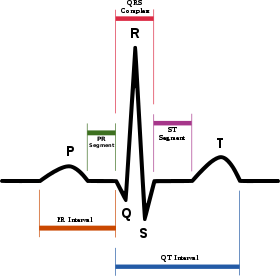
">